Naive Bayes Classifiers to predict the type of mouse (WT, AS, PS) from hand trajectory or from neural activity

In [3]:
import sys
import os
sys.path.append(os.path.abspath("C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code"))
import hdf5storage
import mat73
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math

import CURBD.curbd as curbd
import PyalData.pyaldata as pyaldata

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
data_dir_WTM350 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2" 
data_dir_WTM355 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2" 
data_dir_ASM351 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2" 
data_dir_ASM354 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2" 
data_dir_PSM365 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M365/PS-M365-pyaldata2" 
data_dir_PSM366 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M366/PS-M366-pyaldata2" 

Classifier to predict type (WT, AS, PS) from 3d hand trajectory during first half a second after movement onset

In [13]:
# consider all models, and no thalamus: 
from sklearn.model_selection import cross_val_score, KFold

class_indices = {'WT-M350':1,
                'WT-M355':1, 
                'AS-M351':2,
                'AS-M354':2,
                'PS-M365':3,
                'PS-M366':3}
X_data = {'WT':[],'AS':[],'PS':[]}
X = []
y = []

for data_dir in [data_dir_WTM350, data_dir_WTM355, data_dir_ASM351, data_dir_ASM354, data_dir_PSM365, data_dir_PSM366]:
    animal_model = data_dir[-17:-10]
    animal_type = data_dir[-17:-15]
    files = os.listdir(data_dir)
    for file_name in files:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials

        df["trial_id"] = range(len(df))

        if len(df)>1:
            for i in range(len(df)):
                X_data[animal_type].append(df['hand'][i][df['idx_mo'][i]:df['idx_mo'][i]+250,:])
            


In [14]:
random.shuffle(X_data['WT'])
random.shuffle(X_data['AS'])
random.shuffle(X_data['PS'])


min_samples = min(len(X_data['WT']), len(X_data['AS']), len(X_data['PS']))
X_WT = X_data['WT'][0:min_samples]
X_AS = X_data['AS'][0:min_samples]
X_PS = X_data['PS'][0:min_samples]

# Step 3: Combine the sampled subsets
X_balanced = np.concatenate((X_WT, X_AS, X_PS))
y_balanced = np.concatenate((['WT'] * min_samples, ['AS'] * min_samples, ['PS'] * min_samples))

# Optionally, shuffle the combined dataset
indices = np.arange(len(X_balanced))
np.random.shuffle(indices)
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]

X_balanced_reshaped = X_balanced.reshape(len(X_balanced),-1)  # convert to 2d array (needed for the NB classifier)
y_balanced_reshaped = y_balanced.reshape(len(y_balanced),-1)


# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced_reshaped, y_balanced_reshaped, test_size=0.2, random_state=42)



In [15]:
np.shape(X_balanced)

(705, 250, 3)

In [16]:
np.shape(X_balanced_reshaped)

(705, 750)

In [17]:
# Initialize Gaussian Naive Bayes classifier
classifier = GaussianNB()

# Train classifier
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8439716312056738


c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
from sklearn.model_selection import cross_val_score, KFold
# Define k for k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
scores = cross_val_score(classifier, X_balanced_reshaped, y_balanced_reshaped, cv=kf)
scores

c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConve

array([0.84397163, 0.86524823, 0.87234043, 0.89361702, 0.88652482])

Classifier to predict type (WT, AS, PS) from hand velocity during first half a second after movement onset

In [19]:
# consider all models, and no thalamus: 

class_indices = {'WT-M350':1,
                'WT-M355':1, 
                'AS-M351':2,
                'AS-M354':2,
                'PS-M365':3,
                'PS-M366':3}
X_data = {'WT':[],'AS':[],'PS':[]}
X = []
y = []

for data_dir in [data_dir_WTM350, data_dir_WTM355, data_dir_ASM351, data_dir_ASM354, data_dir_PSM365, data_dir_PSM366]:
    animal_model = data_dir[-17:-10]
    animal_type = data_dir[-17:-15]
    files = os.listdir(data_dir)
    for file_name in files:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials

        df["trial_id"] = range(len(df))

        if len(df)>1:
            for i in range(len(df)):
                X_data[animal_type].append(df['vel'][i][df['idx_mo'][i]:df['idx_mo'][i]+250])
            


In [20]:
random.shuffle(X_data['WT'])
random.shuffle(X_data['AS'])
random.shuffle(X_data['PS'])


min_samples = min(len(X_data['WT']), len(X_data['AS']), len(X_data['PS']))
X_WT = X_data['WT'][0:min_samples]
X_AS = X_data['AS'][0:min_samples]
X_PS = X_data['PS'][0:min_samples]

# Step 3: Combine the sampled subsets
X_balanced = np.concatenate((X_WT, X_AS, X_PS))
y_balanced = np.concatenate((['WT'] * min_samples, ['AS'] * min_samples, ['PS'] * min_samples))

# Optionally, shuffle the combined dataset
indices = np.arange(len(X_balanced))
np.random.shuffle(indices)
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]

X_balanced_reshaped = X_balanced.reshape(len(X_balanced),-1)  # convert to 2d array (needed for the NB classifier)
y_balanced_reshaped = y_balanced.reshape(len(y_balanced),-1)


# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced_reshaped, y_balanced_reshaped, test_size=0.2, random_state=42)



In [21]:
# Initialize Gaussian Naive Bayes classifier
classifier = GaussianNB()

# Train classifier
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7092198581560284


c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
# Define k for k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
scores = cross_val_score(classifier, X_balanced_reshaped, y_balanced_reshaped, cv=kf)
scores

c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConve

array([0.73758865, 0.72340426, 0.75886525, 0.76595745, 0.71631206])

In [ ]:
np.shape(df.vel[1])

(101,)

Classifier to predict type (WT, AS, PS) from neural activity during first half a second after movement onset

In [8]:
# consider all models, and no thalamus: compute 5D PCA manifolds for each trial, m1, dcn, str and finally all 3 regions
 
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)

class_indices = {'WT-M350':1,
                'WT-M355':1, 
                'AS-M351':2,
                'AS-M354':2,
                'PS-M365':3,
                'PS-M366':3}
X_data_5 = {'WT':[],'AS':[],'PS':[]}
X_data_m1_5 = {'WT':[],'AS':[],'PS':[]}
X_data_dcn_5 = {'WT':[],'AS':[],'PS':[]}
X_data_str_5 = {'WT':[],'AS':[],'PS':[]}
X = []
y = []

for data_dir in [data_dir_WTM350, data_dir_WTM355, data_dir_ASM351, data_dir_ASM354, data_dir_PSM365, data_dir_PSM366]:
    animal_model = data_dir[-17:-10]
    animal_type = data_dir[-17:-15]
    files = os.listdir(data_dir)
    for file_name in files:
        print(file_name)
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        
        if len(df)>1:
            df["trial_id"] = range(len(df))
            df = pyaldata.combine_time_bins(df, 5)
            spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

            for col in spike_fields:
                df = pyaldata.remove_low_firing_neurons(df, col,  1)
            for col in spike_fields:
                df = pyaldata.transform_signal(df, col,  'sqrt')
            df = pyaldata.merge_signals(df, spike_fields, "all_spikes")
            df = pyaldata.add_firing_rates(df, 'smooth')
            df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=50)  # consider half a second before and after movement onset

            #concat_all_rates = pyaldata.concat_trials(df, 'all_rates')
            #all_pca = pca.fit_transform(concat_all_rates)
            #X_data[animal_type].append(all_pca)

            for i in range(len(df)):
                if np.shape(df.all_rates[i])[1]>=10:
                    all_pca = np.transpose(pca.fit_transform(df.all_rates[i]))
                    X_data_5[animal_type].append(all_pca)

                if np.shape(df.m1_rates[i])[1]>=10:
                    m1_pca = np.transpose(pca.fit_transform(df.m1_rates[i]))
                    X_data_m1_5[animal_type].append(m1_pca)

                if np.shape(df.str_rates[i])[1]>=10:
                    str_pca = np.transpose(pca.fit_transform(df.str_rates[i]))
                    X_data_str_5[animal_type].append(str_pca)

                if np.shape(df.dcn_rates[i])[1]>=10:
                    dcn_pca = np.transpose(pca.fit_transform(df.dcn_rates[i]))
                    X_data_dcn_5[animal_type].append(dcn_pca)


WT-M350_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M350_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M350_session3.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M350_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M350_session5.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M350_session6.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M350_session7.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M350_session8.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M355_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M355_session10.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1 

WT-M355_session11.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M355_session12.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [3]

WT-M355_session13.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [ 7

WT-M355_session14.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [11

WT-M355_session15.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [6]

WT-M355_session16.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M355_session17.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M355_session18.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [13

WT-M355_session19.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [4]

WT-M355_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M355_session20.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M355_session21.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M355_session23.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M355_session3.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M355_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [31

WT-M355_session5.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [35

WT-M355_session6.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [10

WT-M355_session7.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [16

WT-M355_session8.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


WT-M355_session9.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1]

AS-M351_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


AS-M351_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


AS-M351_session3.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


AS-M351_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [10

AS-M351_session5.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [3]

AS-M351_session6.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


AS-M351_session7.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


AS-M351_session8.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1]

AS-M354_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


AS-M354_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


AS-M354_session3.mat
AS-M354_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


AS-M354_session5.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


AS-M354_session6.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


AS-M354_session7.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


AS-M354_session8.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


PS-M365_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [20

PS-M365_session10.mat
PS-M365_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


PS-M365_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


PS-M365_session5.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


PS-M365_session6.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


PS-M365_session7.mat
PS-M365_session9.mat
PS-M366_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


PS-M366_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


PS-M366_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_19532\615250044.py:41: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [41

PS-M366_session5.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


PS-M366_session6.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


PS-M366_session8.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [9]:
np.shape(m1_pca)

(10, 101)

In [11]:
# Decoder from 10D PCA m1 activity to type:

import random

random.shuffle(X_data_m1_5['WT'])
random.shuffle(X_data_m1_5['AS'])
random.shuffle(X_data_m1_5['PS'])

min_samples = min(len(X_data_m1_5['WT']), len(X_data_m1_5['AS']), len(X_data_m1_5['PS']))
X_WT = X_data_m1_5['WT'][0:min_samples]
X_AS = X_data_m1_5['AS'][0:min_samples]
X_PS = X_data_m1_5['PS'][0:min_samples]

# Step 3: Combine the sampled subsets
X_balanced = np.concatenate((X_WT, X_AS, X_PS))
y_balanced = np.concatenate((['WT'] * min_samples, ['AS'] * min_samples, ['PS'] * min_samples))

# Optionally, shuffle the combined dataset
indices = np.arange(len(X_balanced))
np.random.shuffle(indices)
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]

X_balanced_reshaped = X_balanced.reshape(len(X_balanced),-1)  # convert to 2d array (needed for the NB classifier)
y_balanced_reshaped = y_balanced.reshape(len(y_balanced),-1)


# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced_reshaped, y_balanced_reshaped, test_size=0.2, random_state=10)


# Initialize Gaussian Naive Bayes classifier
classifier = GaussianNB()

# Train classifier
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)



Accuracy: 0.5740740740740741


c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
# Define k for k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=40)

# Perform k-fold cross-validation
scores = cross_val_score(classifier, X_balanced_reshaped, y_balanced_reshaped, cv=kf)
scores

NameError: name 'KFold' is not defined

In [ ]:
# Decoder from 10D PCA str activity to type:


random.shuffle(X_data_str_5['WT'])
random.shuffle(X_data_str_5['AS'])
random.shuffle(X_data_str_5['PS'])

min_samples = min(len(X_data_str_5['WT']), len(X_data_str_5['AS']), len(X_data_str_5['PS']))
X_WT = X_data_str_5['WT'][0:min_samples]
X_AS = X_data_str_5['AS'][0:min_samples]
X_PS = X_data_str_5['PS'][0:min_samples]

# Step 3: Combine the sampled subsets
X_balanced = np.concatenate((X_WT, X_AS, X_PS))
y_balanced = np.concatenate((['WT'] * min_samples, ['AS'] * min_samples, ['PS'] * min_samples))

# Optionally, shuffle the combined dataset
indices = np.arange(len(X_balanced))
np.random.shuffle(indices)
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]

X_balanced_reshaped = X_balanced.reshape(len(X_balanced),-1)  # convert to 2d array (needed for the NB classifier)
y_balanced_reshaped = y_balanced.reshape(len(y_balanced),-1)


# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced_reshaped, y_balanced_reshaped, test_size=0.2, random_state=10)


# Initialize Gaussian Naive Bayes classifier
classifier = GaussianNB()

# Train classifier
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)



Accuracy: 0.6357142857142857


c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Define k for k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
scores = cross_val_score(classifier, X_balanced_reshaped, y_balanced_reshaped, cv=kf)
scores

c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConve

array([0.60714286, 0.54676259, 0.61151079, 0.60431655, 0.61870504])

In [ ]:
# Decoder from 5D PCA dcn activity to type:

random.shuffle(X_data_dcn_5['WT'])
random.shuffle(X_data_dcn_5['AS'])
random.shuffle(X_data_dcn_5['PS'])

min_samples = min(len(X_data_dcn_5['WT']), len(X_data_dcn_5['AS']), len(X_data_dcn_5['PS']))
X_WT = X_data_dcn_5['WT'][0:min_samples]
X_AS = X_data_dcn_5['AS'][0:min_samples]
X_PS = X_data_dcn_5['PS'][0:min_samples]

# Step 3: Combine the sampled subsets
X_balanced = np.concatenate((X_WT, X_AS, X_PS))
y_balanced = np.concatenate((['WT'] * min_samples, ['AS'] * min_samples, ['PS'] * min_samples))

# Optionally, shuffle the combined dataset
indices = np.arange(len(X_balanced))
np.random.shuffle(indices)
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]

X_balanced_reshaped = X_balanced.reshape(len(X_balanced),-1)  # convert to 2d array (needed for the NB classifier)
y_balanced_reshaped = y_balanced.reshape(len(y_balanced),-1)


# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced_reshaped, y_balanced_reshaped, test_size=0.2, random_state=10)


# Initialize Gaussian Naive Bayes classifier
classifier = GaussianNB()

# Train classifier
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)



Accuracy: 0.5857142857142857


c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Define k for k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
scores = cross_val_score(classifier, X_balanced_reshaped, y_balanced_reshaped, cv=kf)
scores

c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConve

array([0.62857143, 0.57553957, 0.61151079, 0.58273381, 0.6618705 ])

In [ ]:
# Decoder from 5D PCA all activity to type:

random.shuffle(X_data_5['WT'])
random.shuffle(X_data_5['AS'])
random.shuffle(X_data_5['PS'])

min_samples = min(len(X_data_5['WT']), len(X_data_5['AS']), len(X_data_5['PS']))
X_WT = X_data_5['WT'][0:min_samples]
X_AS = X_data_5['AS'][0:min_samples]
X_PS = X_data_5['PS'][0:min_samples]

# Step 3: Combine the sampled subsets
X_balanced = np.concatenate((X_WT, X_AS, X_PS))
y_balanced = np.concatenate((['WT'] * min_samples, ['AS'] * min_samples, ['PS'] * min_samples))

# Optionally, shuffle the combined dataset
indices = np.arange(len(X_balanced))
np.random.shuffle(indices)
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]

X_balanced_reshaped = X_balanced.reshape(len(X_balanced),-1)  # convert to 2d array (needed for the NB classifier)
y_balanced_reshaped = y_balanced.reshape(len(y_balanced),-1)


# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced_reshaped, y_balanced_reshaped, test_size=0.2, random_state=10)


# Initialize Gaussian Naive Bayes classifier
classifier = GaussianNB()

# Train classifier
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)



Accuracy: 0.5071428571428571


c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Define k for k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
scores = cross_val_score(classifier, X_balanced_reshaped, y_balanced_reshaped, cv=kf)
scores

c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConve

array([0.53571429, 0.50359712, 0.58273381, 0.49640288, 0.52517986])

In [ ]:
# Decoder from 5D PCA all activity to type:

random.shuffle(X_data_5['WT'])
random.shuffle(X_data_5['AS'])
random.shuffle(X_data_5['PS'])

min_samples = min(len(X_data_5['WT']), len(X_data_5['AS']), len(X_data_5['PS']))
X_WT = X_data_5['WT'][0:min_samples]
X_AS = X_data_5['AS'][0:min_samples]
X_PS = X_data_5['PS'][0:min_samples]

# Step 3: Combine the sampled subsets
X_balanced = np.concatenate((X_WT, X_AS, X_PS))
y_balanced = np.concatenate((['WT'] * min_samples, ['AS'] * min_samples, ['PS'] * min_samples))

# Optionally, shuffle the combined dataset
indices = np.arange(len(X_balanced))
np.random.shuffle(indices)
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]


X_balanced_reshaped = X_balanced.reshape(len(X_balanced),-1)  # convert to 2d array (needed for the NB classifier)
y_balanced_reshaped = y_balanced.reshape(len(y_balanced),-1)

# Shuffle X_balanced_reshaped for control performance:
random.shuffle(X_balanced_reshaped)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced_reshaped, y_balanced_reshaped, test_size=0.2, random_state=10)


# Initialize Gaussian Naive Bayes classifier
classifier = GaussianNB()

# Train classifier
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)



Accuracy: 0.3


c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Define k for k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation

# Shuffle X_balanced_reshaped for control:
random.shuffle(X_balanced_reshaped)
scores = cross_val_score(classifier, X_balanced_reshaped, y_balanced_reshaped, cv=kf)
scores

c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConve

array([0.29285714, 0.35251799, 0.27338129, 0.33093525, 0.23021583])

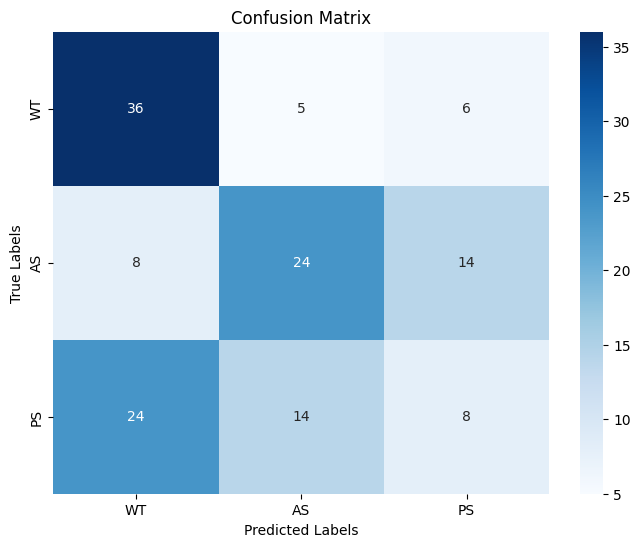

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Compute the confusion matrix
class_names = ['WT','AS','PS']

cm = confusion_matrix(y_test, predictions, labels=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


Stratified K-Fold Cross-Validation
Fold 1, Accuracy: 0.54


c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


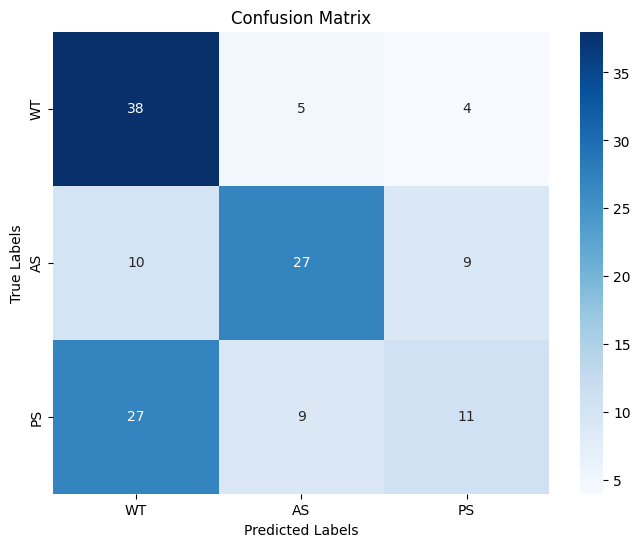

Fold 2, Accuracy: 0.51


c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


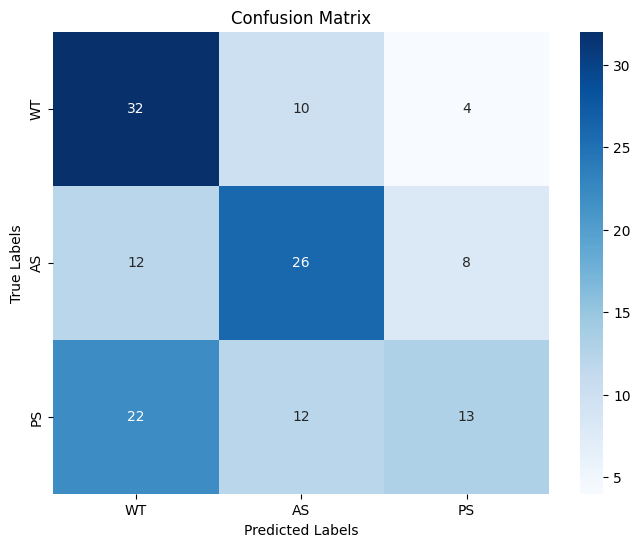

c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 3, Accuracy: 0.47


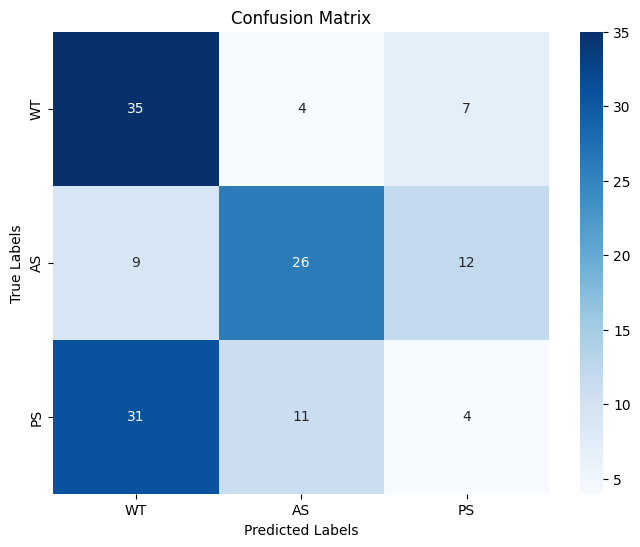

Fold 4, Accuracy: 0.54


c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


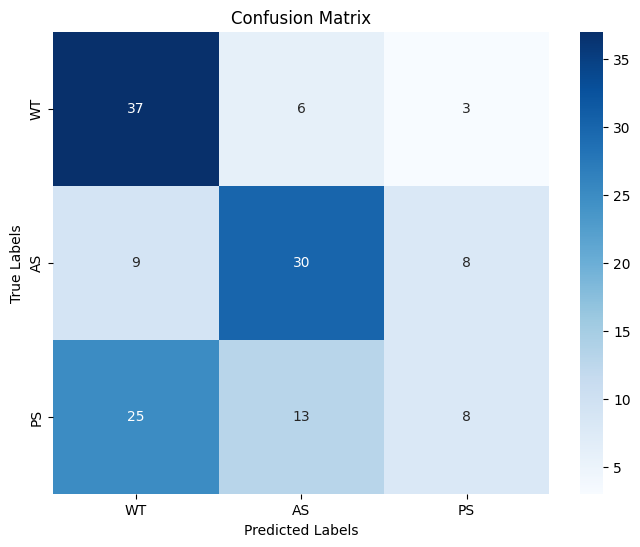

Fold 5, Accuracy: 0.49


c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


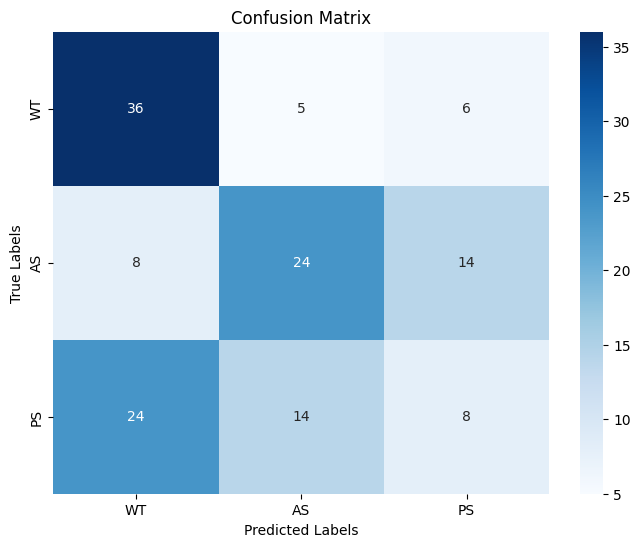

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

# Sample data
X = X_balanced_reshaped  # Feature array
y = y_balanced_reshaped  # Class labels

# Stratified K-Fold Cross-Validation
print("Stratified K-Fold Cross-Validation")
skf = StratifiedKFold(n_splits=5)
fold = 0
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Fold {fold + 1}, Accuracy: {accuracy:.2f}")
    fold +=1

    class_names = ['WT','AS','PS']

    cm = confusion_matrix(y_test, predictions, labels=class_names)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()











In [ ]:
cm

array([[21, 16,  9],
       [ 9, 23, 14],
       [ 5, 13, 28]], dtype=int64)

In [ ]:
predictions=='WT'

array([ True,  True,  True, False,  True,  True,  True,  True, False,
       False, False,  True,  True, False, False, False, False, False,
       False,  True, False, False, False, False,  True, False,  True,
        True, False,  True, False, False, False,  True,  True, False,
       False, False,  True, False,  True,  True,  True, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True, False, False,  True, False,  True,  True,  True,
       False, False, False, False,  True,  True,  True, False, False,
        True,  True,  True, False,  True,  True, False,  True, False,
        True, False, False,  True, False,  True, False, False, False,
        True,  True, False, False, False,  True, False, False,  True,
       False,  True,  True, False, False,  True,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,

In [ ]:
y_test=='WT'

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [